In [1]:
%matplotlib inline
# imported necessary libraries
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import cross_val_score
#from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
#from sklearn import cross_validation
from sklearn.model_selection import cross_validate


# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 limit 1000
""", con) 

def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'




In [2]:


#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative


In [3]:
filtered_data.shape #looking at the number of attributes and size of the data
#filtered_data.head()

(1000, 10)

In [4]:


#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')



In [5]:
final = sorted_data.drop_duplicates(subset = {"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(998, 10)

In [6]:
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.8

In [7]:


final = final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]



In [8]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(998, 10)


positive    841
negative    157
Name: Score, dtype: int64

In [9]:
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    

0
I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed.<br /><br />Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.<br /><br />If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.<br /><br />Thank you for the personal, incredible service!


In [10]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'which', 'below', "wouldn't", "she's", 'mustn', "that'll", "wasn't", "won't", 'she', 'they', 't', 'you', 'few', 'no', 'itself', 's', 'haven', "shan't", 'same', 'having', 'o', 'had', 'both', 'ours', 'here', 'a', 'these', 'about', 'there', 'him', 'them', 'in', 'each', 'yourself', "couldn't", 'did', 'as', 'all', 'so', 'once', 'its', 'down', 'is', 'because', 'the', "hasn't", 'very', 'were', 'it', 'out', "doesn't", 'isn', 'an', "didn't", 'where', 'when', 'd', 'herself', 'some', 'needn', 'until', 'don', 'was', 'their', 'over', 'am', 'are', "mightn't", "aren't", 'our', "you're", 'through', 'yours', 'or', 'to', 'what', 've', 'ma', 'shouldn', 'my', 'this', 'aren', 'too', 'into', "shouldn't", "should've", 'he', 'nor', 'been', 'can', "hadn't", 'only', 'hasn', 'hadn', 'at', 'your', 'before', 'yourselves', 'doing', 'and', 'then', 'now', 'being', 'further', 'mightn', 'we', 'off', 'if', 'above', 'm', 'those', 'does', 'wasn', 'such', 'why', 'i', 'himself', 'didn', "isn't", 'be', 'y', 'doesn', 'her', 

In [11]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [12]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

In [14]:
final['CleanedText']

10     b'dont know cactus tequila uniqu combin ingred...
232    b'five minut one tentacl bitten ball insid cra...
171    b'scotti full hot spot use within week hot spo...
932    b'tri found salti plus ate fish sauc fish real...
893    b'gravi mix excel except dont use water call u...
894    b'south live sometim get southern influenc gra...
895    b'noth easier noth better even beat grandmoth ...
896    b'use pioneer gravi number year easi make tast...
380    b'alway pleasur find french product web market...
379    b'best way cook roast local groceri went buis ...
378    b'love product cant find local sometim littl w...
319    b'chocol cover espresso bean wonder chocol dar...
316    b'order coffe theme wed arriv fight friend sme...
318    b'product exact advertis fresh unfortun keep c...
317    b'delici chocol excel espresso bean perfect ro...
791    b'cant eat oat funni tast kid also think tast ...
790    b'good qualiti oat packag came time oat work w...
789    b'product fresh good get

In [15]:
final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [16]:
con = sqlite3.connect("final.sqlite")
cleaned_data = pd.read_sql_query("select * from Reviews", con)

In [17]:
cleaned_data.shape

(998, 12)

In [81]:
#cleaned_data.head()

In [18]:
cleaned_data["Score"].value_counts()

positive    841
negative    157
Name: Score, dtype: int64

In [19]:
# To randomly sample 100k points from both class

data_pos = cleaned_data[cleaned_data["Score"] == "positive"].sample(n = 50)
data_neg = cleaned_data[cleaned_data["Score"] == "negative"].sample(n = 50)
final_100k = pd.concat([data_pos, data_neg])
final_100k.shape

(100, 12)

In [20]:
final_100k["Time"] = pd.to_datetime(final_100k["Time"], unit = "s")
final_100k = final_100k.sort_values(by = "Time")
#final_100k.head()

In [75]:
# 100k data which will use to train model after vectorization
X = final_100k["CleanedText"]
print("shape of X:", X.shape)
X

shape of X: (100,)


121    b'cant believ wonder chip slight spici tast gi...
539    b'good instant oatmeal best oatmeal brand use ...
576    b'live dorm without kitchen make cup coffe rea...
238    b'dont write mani review say kettl brand chip ...
519    b'discov mix amazon alway bought whole food st...
103    b'husband mexican picki tortilla chip absolut ...
268    b'tri lot chip best real sea salt real vinegar...
349    b'want realli good snack bar tri healthi tast ...
187    b'chip good couldnt stop eat didnt last long r...
106    b'chip salti hint sweet crisp crunchi best chi...
196    b'husband like lot bit differ get use less gre...
94     b'nice case chip quit tasti definit enjoy kett...
111    b'love product differ flavor fantast famili li...
445    b'salsa smell delici think probabl unfortun pe...
241    b'perhap worst chip ever gone mouth entir life...
166    b'dont know case chip receiv everyon allow sam...
351    b'great tast great ingredi great textur absolu...
396    b'purchas read natur cur

In [22]:
# class label
y =final_100k["Score"]
print("shape of y:", y.shape)
#y=np.where([['positive', 'negative'], [1, 0]])
y

shape of y: (100,)


121    positive
539    positive
576    positive
238    positive
519    positive
103    positive
268    positive
349    positive
187    positive
106    positive
196    positive
94     positive
111    positive
445    negative
241    negative
166    negative
351    positive
396    negative
438    negative
367    negative
709    positive
581    positive
426    positive
710    positive
456    negative
363    negative
480    positive
366    negative
557    positive
45     negative
         ...   
168    negative
691    negative
878    positive
931    positive
666    positive
831    positive
597    positive
412    positive
662    positive
400    negative
377    positive
305    negative
314    positive
941    negative
996    positive
932    negative
981    positive
24     negative
833    positive
90     negative
437    positive
971    negative
642    negative
984    negative
933    negative
521    positive
972    negative
942    negative
312    positive
430    negative
Name: Score, dtype: obje

In [23]:
#Score as positive/negative -> 0/1
def polarity(x):
    if x == "positive":
        return 0
    else:
        return 1
y =y.map(polarity) #Map all the scores as the function polarity i.e. positive or negative
y

121    0
539    0
576    0
238    0
519    0
103    0
268    0
349    0
187    0
106    0
196    0
94     0
111    0
445    1
241    1
166    1
351    0
396    1
438    1
367    1
709    0
581    0
426    0
710    0
456    1
363    1
480    0
366    1
557    0
45     1
      ..
168    1
691    1
878    0
931    0
666    0
831    0
597    0
412    0
662    0
400    1
377    0
305    1
314    0
941    1
996    0
932    1
981    0
24     1
833    0
90     1
437    0
971    1
642    1
984    1
933    1
521    0
972    1
942    1
312    0
430    1
Name: Score, dtype: int64

In [24]:
y

121    0
539    0
576    0
238    0
519    0
103    0
268    0
349    0
187    0
106    0
196    0
94     0
111    0
445    1
241    1
166    1
351    0
396    1
438    1
367    1
709    0
581    0
426    0
710    0
456    1
363    1
480    0
366    1
557    0
45     1
      ..
168    1
691    1
878    0
931    0
666    0
831    0
597    0
412    0
662    0
400    1
377    0
305    1
314    0
941    1
996    0
932    1
981    0
24     1
833    0
90     1
437    0
971    1
642    1
984    1
933    1
521    0
972    1
942    1
312    0
430    1
Name: Score, dtype: int64

In [25]:
from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape, x_test.shape)

(70,) (70,) (30,)


In [26]:
from sklearn.feature_extraction.text import CountVectorizer 

bow = CountVectorizer()
X_train = bow.fit_transform(X_train)

In [27]:
x_test = bow.transform(x_test)

In [28]:

from sklearn import preprocessing
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)


Train Data Size:  (70, 940)


In [29]:

x_test = preprocessing.normalize(x_test)
#print("Test Data Size: ",x_test.shape)


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.63 µs
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision',

Fitting 10 folds for each of 30 candidates, totalling 300 fits


/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-pac

Fitting 10 folds for each of 30 candidates, totalling 300 fits


/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-pac

Fitting 10 folds for each of 30 candidates, totalling 300 fits


/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-pac

Fitting 10 folds for each of 30 candidates, totalling 300 fits


/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-pac

Fitting 10 folds for each of 30 candidates, totalling 300 fits


/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-pac

Fitting 10 folds for each of 30 candidates, totalling 300 fits


/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-pac

Fitting 10 folds for each of 30 candidates, totalling 300 fits


/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-pac

Fitting 10 folds for each of 30 candidates, totalling 300 fits


/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-pac

Fitting 10 folds for each of 30 candidates, totalling 300 fits


/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-pac

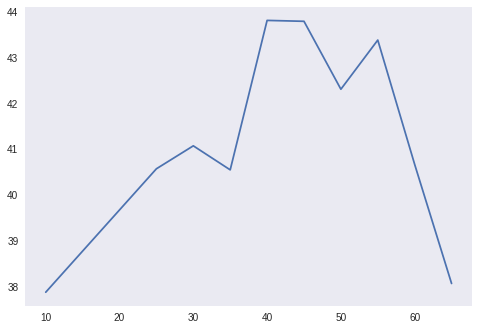

In [30]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint as sp_randint
%time
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint as sp_randint
g = sp_randint(2,300)
a=[]
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)
for train, cv in tscv.split(X_train):
#     print("%s %s" % (train, cv))
    #print(X_train[train].shape, X_train[cv].shape)
    clf = DecisionTreeClassifier()
    param_grid = {'max_depth':sorted(g.rvs(30))} #params we need to try on classifier
    tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
    gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='f1')
    gsv.fit(X_train,y_train)
    #print("Best HyperParameter: ",gsv.best_params_)
    #print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))
    c=gsv.best_score_*100
    a.append(c)
    #print('tsssv', cv)
    #plt.plot( X_train[cv],c)
    #fig = plt.figure()
    #plt.show()'''
#print (cv)   
Y=[70.60317460317461, 70.26984126984127, 70.16666666666666, 70.42857142857142, 69.11904761904762, 71.05555555555554, 71.65079365079364, 69.62698412698413, 70.66666666666666, 70.66666666666667]
X=[10,25,30,35,40,45,50,55,60,65]
plt.plot(X,a) 
plt.grid() ## Show the grids
plt.show()
#print(a)

In [95]:
%time
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint as sp_randint

g = sp_randint(2,300)
clf = DecisionTreeClassifier()
param_grid = {'max_depth':sorted(g.rvs(30))} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='f1')
gsv.fit(X_train,y_train)
#savetofile(gsv,"Decision Trees/gsv_tfidf")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))
c=gsv.best_score_*100

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision',

Best HyperParameter:  {'max_depth': 131}
Best Accuracy: 58.55%


/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done 300 out of 300 | elap

In [96]:
# Bagged Decision Trees for Classification
import pandas
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
seed = 7

In [97]:

kfold = model_selection.KFold(n_splits=10, random_state=seed)
cart = DecisionTreeClassifier()
num_trees = 100

In [98]:


model = BaggingClassifier(base_estimator=cart, n_estimators=num_trees, random_state=seed)
results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold)
print (results)

[0.71428571 0.71428571 0.71428571 0.85714286 0.57142857 0.85714286
 0.71428571 0.28571429 0.85714286 0.71428571]


In [99]:
import pandas
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier

In [123]:
seed = 7
num_trees = 100
max_features = 3
#kfold = model_selection.KFold(n_splits=10, random_state=seed)
model = RandomForestClassifier(n_estimators=num_trees, max_features=max_features)
results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold)
print(results.mean())
print(model)
print(kfold)

0.5996732026143792
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
KFold(n_splits=4, random_state=None, shuffle=False)


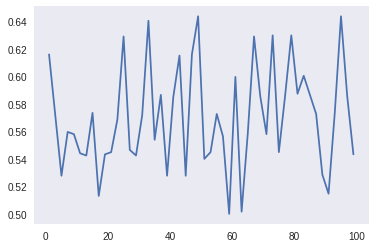

In [111]:
num_trees1=[]
result2=[]
for i in range(1,100,2):
        #print (i)
        num_trees1.append(i)
        kfold = model_selection.KFold(n_splits=4, random_state=None)
        model = RandomForestClassifier(n_estimators=i, max_features=max_features)
        results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold)
        #print(results.mean())
        result1=results.mean()
        result2.append(result1)
X=num_trees1     
Y=result2
plt.plot(X,Y) 
plt.grid() ## Show the grids
plt.show()

In [112]:
model = RandomForestClassifier(random_state=42)

In [113]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [116]:
CV_rfc = GridSearchCV(estimator=model, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'n_estimators': [200, 500], 'max_depth': [4, 5, 6, 7, 8], 'max_features': ['auto', 'sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [117]:

CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'log2',
 'n_estimators': 500}

In [124]:
model = RandomForestClassifier(n_estimators=500, max_features=max_features,criterion='gini',max_depth=4)
results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold)
print(results.mean())

0.45833333333333337


In [ ]:
seed = 7
num_trees = 100
max_features = 3
#kfold = model_selection.KFold(n_splits=10, random_state=seed)
model = RandomForestClassifier(n_estimators=num_trees, max_features=max_features)
results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold)
print(results.mean())
print(model)
print(kfold)

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

In [319]:
kfold = model_selection.KFold(n_splits=10, random_state=seed)
model = ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)
results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold)
print(results.mean())

0.5285714285714286


In [321]:
from sklearn.ensemble import AdaBoostClassifier
kfold = model_selection.KFold(n_splits=10, random_state=seed)
model = AdaBoostClassifier(n_estimators=num_trees, random_state=seed)
results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold)
print(results.mean())

0.5999999999999999


In [323]:
# Voting Ensemble for Classification
import pandas
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed)
# create the sub models
estimators = []
model1 = LogisticRegression()
estimators.append(('logistic', model1))
model2 = DecisionTreeClassifier()
estimators.append(('cart', model2))
model3 = SVC()
estimators.append(('svm', model3))
# create the ensemble model
ensemble = VotingClassifier(estimators)
results = model_selection.cross_val_score(ensemble, X_train, y_train, cv=kfold)
print(results.mean())

0.5571428571428572


/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or '

In [128]:
import pandas
from sklearn import model_selection
from sklearn.ensemble import GradientBoostingClassifier
seed = 7
num_trees = 100
max_features = 3
kfold = model_selection.KFold(n_splits=10, random_state=seed)
model = GradientBoostingClassifier(n_estimators=num_trees, max_features=max_features)
results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold)
print(results.mean())

0.5857142857142856


In [129]:
model =GradientBoostingClassifier(random_state=42)

In [151]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': [ 'sqrt', 'log2','auto'],
    'max_depth' : [3,4,5,6,7,8],
    'learning_rate' :[0.0000001,.1]
   
}

In [152]:
CV_rfc = GridSearchCV(estimator=model, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sam...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': [1e-07, 0.1], 'n_estimators': [200, 500], 'max_depth': [3, 4, 5, 6, 7, 8], 'max_features': ['sqrt', 'log2', 'auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [153]:
CV_rfc.best_params_

{'learning_rate': 1e-07,
 'max_depth': 3,
 'max_features': 'auto',
 'n_estimators': 200}

In [156]:
model = GradientBoostingClassifier(n_estimators=200, max_features='auto')
results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold)
print(results.mean())

0.5980392156862745


In [246]:
%time
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint as sp_randint

g = sp_randint(2,300)
clf = DecisionTreeClassifier()
param_grid = {'max_depth':sorted(g.rvs(30))} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='f1')
#c=gsv.best_score_*100
#a_gsv=gsv.fit(X_train,y_train)
#savetofile(gsv,"gsv.uni")
print("Best HyperParameter: ",gsv.best_params_)
#print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))
#print('gsssv', gsv)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs


AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [ ]:
'''lt.xlim(0,300)
plt.ylim(0.0,0.3)
plt.xlabel(r"max depth",fontsize=15)
plt.ylabel("f1-score")
plt.title(r'F1 Score v/s Max Depth')'''
plt.plot(x,y)
plt.show()

In [71]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

y

CPU times: user 19 µs, sys: 0 ns, total: 19 µs
Wall time: 22.6 µs


In [77]:
print("shape of X:", y.shape)

shape of X: (100,)


In [78]:
#Breaking into Train and test
#X_train, X_test, y_train, y_test = train_test_split(df_sample['CleanedText'].values,df_sample['Score'].values,test_size=0.3,shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
#train_test_split(X, y, test_size = 0.3, random_state = 42)
tfidf = TfidfVectorizer(ngram_range=(1,2)) #Using bi-grams
X_train = tfidf.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = tfidf.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (70, 3199)
Test Data Size:  (30, 3199)


In [79]:
import pandas
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier

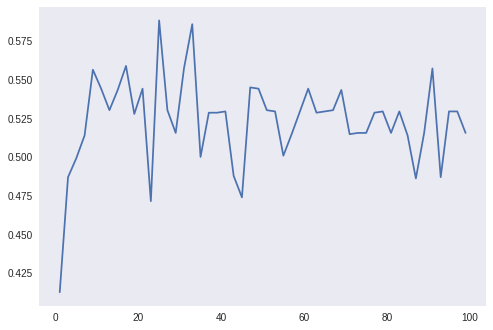

In [80]:
num_trees1=[]
result2=[]
for i in range(1,100,2):
        #print (i)
        num_trees1.append(i)
        kfold = model_selection.KFold(n_splits=4, random_state=None)
        model = RandomForestClassifier(n_estimators=i, max_features=max_features)
        results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold)
        #print(results.mean())
        result1=results.mean()
        result2.append(result1)
X=num_trees1     
Y=result2
plt.plot(X,Y) 
plt.grid() ## Show the grids
plt.show()

In [81]:
model = RandomForestClassifier(random_state=42)

In [82]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [84]:
CV_rfc = GridSearchCV(estimator=model, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

/root/anaconda2/envs/py34/lib/python3.4/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [4, 5, 6, 7, 8], 'n_estimators': [200, 500], 'max_features': ['auto', 'sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [85]:
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 6,
 'max_features': 'auto',
 'n_estimators': 500}

In [94]:
model = RandomForestClassifier(n_estimators=500, max_features='auto',criterion='entropy',max_depth=6)
results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold)
print(results.mean())

0.4722222222222222


In [ ]:
%time
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint as sp_randint

g = sp_randint(2,300)
clf = DecisionTreeClassifier()
param_grid = {'max_depth':sorted(g.rvs(30))} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='f1')
gsv.fit(X_train,y_train)
#savetofile(gsv,"Decision Trees/gsv_tfidf")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

In [ ]:
import pandas
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier

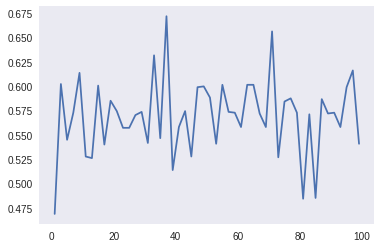

In [154]:
num_trees1=[]
result2=[]
for i in range(1,100,2):
        #print (i)
        num_trees1.append(i)
        kfold = model_selection.KFold(n_splits=4, random_state=None)
        model = RandomForestClassifier(n_estimators=i, max_features=max_features)
        results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold)
        #print(results.mean())
        result1=results.mean()
        result2.append(result1)
X=num_trees1     
Y=result2
plt.plot(X,Y) 
plt.grid() ## Show the grids
plt.show()

In [31]:
from gensim.models import KeyedVectors

#Loading the model from file in the disk
w2vec_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True) 

In [32]:
w2v_vocub = w2vec_model.wv.vocab
len(w2v_vocub)

/root/anaconda2/envs/py34/lib/python3.4/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if __name__ == '__main__':


3000000

In [33]:
%%time
avg_vec_google = [] #List to store all the avg w2vec's 
# no_datapoints = 364170
# sample_cols = random.sample(range(1, no_datapoints), 20001)
for sent in final_100k["CleanedText"]:
    cnt = 0 #to count no of words in each reviews
    sent_vec = np.zeros(300) #Initializing with zeroes
#     print("sent:",sent) 
    sent = sent.decode("utf-8") 
    for word in sent.split():
        try:
#             print(word)
            wvec = w2vec_model.wv[word] #Vector of each using w2v model
#             print("wvec:",wvec)
            sent_vec += wvec #Adding the vectors
#             print("sent_vec:",sent_vec)
            cnt += 1
        except: 
            pass #When the word is not in the dictionary then do nothing  
#     print(sent_vec)
    sent_vec /= cnt #Taking average of vectors sum of the particular review
#     print("avg_vec:",sent_vec)
    avg_vec_google.append(sent_vec) #Storing the avg w2vec's for each review
#     print("*******************************************************************")
# print(avg_vec_google)
avg_vec_google = np.array(avg_vec_google)

CPU times: user 39.8 ms, sys: 9.06 ms, total: 48.8 ms
Wall time: 39.5 ms


/root/anaconda2/envs/py34/lib/python3.4/site-packages/ipykernel/__main__.py:12: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [35]:
avg_vec_google

array([[ 0.04516602, -0.05055455,  0.03747341, ..., -0.07660784,
        -0.10468401, -0.01198033],
       [-0.03112657,  0.00053745, -0.01419474, ..., -0.00836826,
         0.01987678,  0.02400106],
       [-0.04353587,  0.0278155 , -0.01305326, ..., -0.03190486,
         0.05610053,  0.03205872],
       ...,
       [-0.02336693,  0.06621742, -0.01037121, ..., -0.03712463,
         0.00594759,  0.01109314],
       [-0.00750498, -0.01456393, -0.04819899, ..., -0.01081261,
        -0.0273414 , -0.05347619],
       [-0.00885331,  0.07667301,  0.03324167, ...,  0.01699909,
        -0.04052734,  0.02398682]])

In [36]:
np.isnan(avg_vec_google).any()

False

In [37]:
mask = ~np.any(np.isnan(avg_vec_google), axis=1)
# print(mask)
avg_vec_google_new = avg_vec_google[mask]
df_sample_new = y[mask]
print(avg_vec_google_new.shape)
print(df_sample_new.shape)

(100, 300)
(100,)


In [38]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

avg_vec_norm = preprocessing.normalize(avg_vec_google_new)

#Not shuffling the data as we want it on time basis
X_train, X_test, y_train, y_test = train_test_split(avg_vec_norm,df_sample_new.values,test_size=0.3,shuffle=False)

In [39]:
import pandas
from sklearn import model_selection
from sklearn.ensemble import GradientBoostingClassifier
seed = 7
num_trees = 100
max_features = 3
kfold = model_selection.KFold(n_splits=10, random_state=seed)
model = GradientBoostingClassifier(n_estimators=num_trees, max_features=max_features)
results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold)
print(results.mean())

0.5428571428571429


In [40]:
model =GradientBoostingClassifier(random_state=42)

In [41]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': [ 'sqrt', 'log2','auto'],
    'max_depth' : [3,4,5,6,7,8],
    'learning_rate' :[0.0000001,.1]
   
}


In [42]:
CV_rfc = GridSearchCV(estimator=model, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': [1e-07, 0.1], 'max_depth': [3, 4, 5, 6, 7, 8], 'n_estimators': [200, 500], 'max_features': ['sqrt', 'log2', 'auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [43]:
CV_rfc.best_params_

{'learning_rate': 0.1,
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 200}

In [53]:
model = GradientBoostingClassifier(n_estimators=200, max_features='auto',learning_rate=0.1)
results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold)
print(results.mean())

0.5571428571428572


In [55]:
import pandas
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier

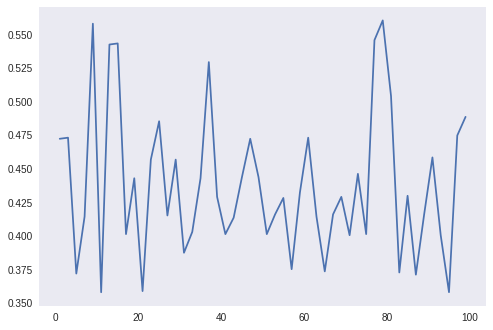

In [56]:
num_trees1=[]
result2=[]
for i in range(1,100,2):
        #print (i)
        num_trees1.append(i)
        kfold = model_selection.KFold(n_splits=4, random_state=None)
        model = RandomForestClassifier(n_estimators=i, max_features=max_features)
        results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold)
        #print(results.mean())
        result1=results.mean()
        result2.append(result1)
X=num_trees1     
Y=result2
plt.plot(X,Y) 
plt.grid() ## Show the grids
plt.show()

In [57]:
model = RandomForestClassifier()

In [58]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [59]:
CV_rfc = GridSearchCV(estimator=model, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [4, 5, 6, 7, 8], 'n_estimators': [200, 500], 'max_features': ['auto', 'sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [60]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'n_estimators': 500}

In [63]:
model = RandomForestClassifier(n_estimators=500, max_features='auto',criterion='gini',max_depth=5)
results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold)
print(results.mean())

0.48774509803921573


In [ ]:
%time
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint as sp_randint

g = sp_randint(2,300)
clf = DecisionTreeClassifier()
param_grid = {'max_depth':sorted(g.rvs(30))} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='f1')
gsv.fit(X_train,y_train)
#savetofile(gsv,"Decision Trees/gsv_aw2v")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

In [165]:
%%time
#Taking Sample Data as it was taking more that 10 hours to computer this block
n_samples = 100
df_sample_new = final_100k["CleanedText"].sample(n_samples)

###Sorting as we want according to time series
#df_sample_new.sort_values('Time',inplace=True) 

###tf-idf with No Stemming
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,2)) #Using bi-grams

tfidf_vec_new = tfidf.fit_transform(final_100k["CleanedText"].values)

#print(tfidf_vec_new.shape)

# tf-idf came up with 2.9 million features for the data corpus
# from sklearn.decomposition import TruncatedSVD

# tsvd_tfidf_ns = TruncatedSVD(n_components=300)#No of components as total dimensions
# tsvd_tfidf_vec_ns = tsvd_tfidf_ns.fit_transform(tfidf_vec_ns)
# print(tsvd_tfidf_ns.explained_variance_ratio_[:].sum())
features = tfidf.get_feature_names()

CPU times: user 23.4 ms, sys: 1.01 ms, total: 24.4 ms
Wall time: 30 ms


In [166]:
df_sample_new

933    b'laddoo turn bad day receiv item insid fridg ...
739    b'singl sell store box singl sure amazon sell ...
767    b'convinc human anim cracker look tast exact l...
641    b'made chocol chip cooki brm garbanzo bean flo...
914    b'husband disappoint coffe weak wateri cup cof...
642    b'candi describ middl almost hard silki smooth...
479    b'mani healthi product dont tast good tast goo...
231    b'great chip great price odd like fish chip so...
626    b'wow soooo good easili becom favorit dress ty...
631    b'recent purchas sale local groceri store know...
337    b'product must qualifi sort decept packag awar...
155    b'best spici chip ever pleasur eat start sweet...
952    b'hot like low star review got sucker see habe...
664    b'use product daili provid steadi stream energ...
190    b'friend mine brought work claim chang life li...
248    b'wow eaten quit potato chip day kettl chip be...
830    b'start drink power slim tea hcg diet help cur...
45     b'triplet eat eventh one

In [190]:
%%time
tfidf_w2v_vec_google = []
review = 0

for sent in final['CleanedText'].values:
    cnt = 0 
    weighted_sum  = 0
    sent_vec = np.zeros(300)
    sent = sent.decode("utf-8") 
    for word in sent.split():
        try:
#             print(word)
            wvec = w2vec_model.wv[word] #Vector of each using w2v model
#             print("w2vec:",wvec)
#             print("tfidf:",tfidf_vec_ns[review,features.index(word)])
            tfidf_vec = tfidf_vec_new[review,features.index(word)]
            sent_vec += (wvec * tfidf_vec)
            weighted_sum += tfidf_vec
        except:
#             print(review)
            pass
#    print(weighted_sum)
    sent_vec /= weighted_sum
    
    tfidf_w2v_vec_google.append(sent_vec)
    review += 1
tfidf_w2v_vec_google = np.array(tfidf_w2v_vec_google)
#savetofile(tfidf_w2v_vec_google,"tfidf_w2v_vec_google")
print('assss' ,sent_vec)

/root/anaconda2/envs/py34/lib/python3.4/site-packages/ipykernel/__main__.py:12: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/root/anaconda2/envs/py34/lib/python3.4/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in true_divide


assss [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan 

In [168]:
#Precomputed File
tfidf_w2v_vec_google = np.array(tfidf_w2v_vec_google)
#Loading the same samples as using precomuted file
df_sample_new = np.array(tfidf_w2v_vec_google)

In [188]:
sent_vec

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [171]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

tfidfw2v_vecs_norm = preprocessing.normalize(tfidf_w2v_vec_google)

#Not shuffling the data as we want it on time basis
X_train, X_test, y_train, y_test = train_test_split(df_sample_new,df_sample_new['Score'].values,test_size=0.3,shuffle=False)
#X_train, X_test, y_train, y_test = train_test_split(tfidfw2v_vecs_norm,df_sample_new['Score'].values,test_size=0.3,shuffle=False)
#X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').